<a href="https://colab.research.google.com/github/yuanic/AutoML-Flower-Classifier/blob/master/Auto_ML_Vision_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Set Up

For this flower classification exercise with AutoML, images were taken from https://www.kaggle.com/olgabelitskaya/flower-color-images#flower_images.zip

In [0]:
#! pip uninstall gcloud google-cloud
#! pip install --upgrade google-cloud-automl

Uninstalling gcloud-0.18.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/gcloud-0.18.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/gcloud/*
Proceed (y/n)? n
Skipping google-cloud as it is not installed.
Requirement already up-to-date: google-cloud-automl in /usr/local/lib/python3.6/dist-packages (0.1.2)


In [0]:
## mount google drive to allow access
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
## path of credential keys
creds = './gdrive/My Drive/nimble-root-216300-361f17cf6445.json'

## 2. Evaluating Model from AutoML Vision

The below contains screenshots from AutoML vision platform based on a score threshold of 0.5.

![Precision Recall Scores](https://raw.githubusercontent.com/yuanic/AutoML-Flower-Classifier/master/precision%20recall%20scores.png)

Precision is a measure of how many of the selected items are relevant. Recall on the other hand is a measure of how many of the relevant items are selected. For a multi-class classification problem, such as the current model with 5 different types of flowers, a possible way to compute the precision and recall metrics is to take the harmonic mean of the precision and recall scores for each class. The current model with a threshold of 0.5 results in a precision of 91.379% and recall of 91.379% as well.

![Confustion matrixt](https://raw.githubusercontent.com/yuanic/AutoML-Flower-Classifier/master/confusion%20matrix.png)

The trained model appears to be effective in finding all roses and sunflowers and have the most trouble identifying tulips. Only 78.3% of all tulips had a correctly predicted label. 

## 3. Credentials & Defining AutoML Vision Function

Predict tab on AutoMIL Vision will allow you to upload an image directly to predict the labels. To move the model to a production interface, Rest API and Python scipt is provided on this same tab. Given that predictions will be made in this colab notebook, the python script was used. Howeveer, a few modifications had to be made:

*   oauth2 service_account command was used to create the credentials that was passed back to set up "prediction_client" 
*   sys.argv was indexed using [1],[2],[3]. This was edited to [0],[1],[2] instead.
*   last line of code to print results was removed



In [0]:
import sys
from google.cloud import automl_v1beta1 as automl
from google.cloud.automl_v1beta1.proto import service_pb2
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(creds)
prediction_client = automl_v1beta1.PredictionServiceClient(credentials=credentials)


In [0]:
def get_prediction(content, project_id, model_id):
  #prediction_client = automl_v1beta1.PredictionServiceClient(credentials=credentials)

  name = 'projects/{}/locations/us-central1/models/{}'.format(project_id, model_id)
  payload = {'image': {'image_bytes': content }}
  params = {}
  request = prediction_client.predict(name, payload, params)
  return request  # waits till request is returned

if __name__ == '__main__':
  file_path = sys.argv[0]
  project_id = sys.argv[1]
  model_id = sys.argv[2]

  with open(file_path, 'rb') as ff:
    content = ff.read()

  #print (get_prediction(content, project_id,  model_id))

## 4. Predicting with Auto ML Vision

The classification model was applied to 2 images additional images of tulips that were not in the original 500 images. Flower 1 was successfully classified as a tulip with as score of 1.0 Flower 2 however was wrongly classified as a rose with a score of 0.89.

To pass a image to the function defined in section 3, we will need to read the image into this notebook as an image converted to bytes format. 

In [0]:
## predict flower 1
with open("./gdrive/My Drive/Colab Notebooks/BAX 452 - Machine Learning Homework/2434178332_7fcf85aa95_n.jpg", "rb") as image:
  f = image.read()
  flower_1 = bytes(f)

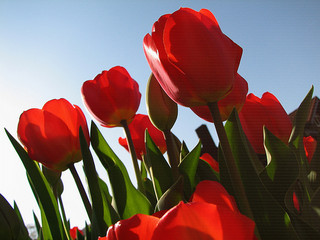

In [0]:
from IPython.display import Image
Image("./gdrive/My Drive/Colab Notebooks/BAX 452 - Machine Learning Homework/2434178332_7fcf85aa95_n.jpg", height=200)

In [0]:
get_prediction(flower_1, "nimble-root-216300",  "ICN6588384437261502046")

payload {
  classification {
    score: 1.0
  }
  display_name: "tulip"
}

In [0]:
## predict flower 2
with open("./gdrive/My Drive/Colab Notebooks/BAX 452 - Machine Learning Homework/4588904196_3c5825c7f4.jpg", "rb") as image:
  f = image.read()
  flower_2 = bytes(f)

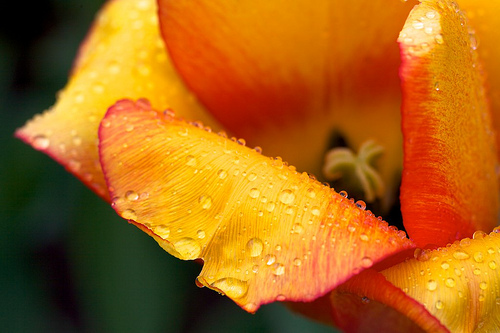

In [0]:
Image("./gdrive/My Drive/Colab Notebooks/BAX 452 - Machine Learning Homework/4588904196_3c5825c7f4.jpg", height=200)

In [0]:
get_prediction(flower_2, "nimble-root-216300",  "ICN6588384437261502046")

payload {
  classification {
    score: 0.8930837512016296
  }
  display_name: "rose"
}

## 5. Conclusion

**Tuning the Model** \
A model can be tuned to improve the precision or recall metric. However, it is not possible to increase both at the same time. An increment in precision will come at the expense of recall vice-versa. The decision to chase after precision or recall will depend on the goal of your model. In cases where we are more concerned with identifying all the relevant cases at the expense of identifying irrelevant items (false positive), the model should be optimized for recall. Examples include detection of diseases to find 100% of at risk patients for follow up testing. 
For flower classification, assuming that the model is used to filter photos to find a specific flower type, we will be more concerned with precision. This ensures that images returned will show a high percentage of relevance and we accept leaving out other possible relevant images.

**Threshold** \
To adjust the model for precision or recall, the threshold parameter is used. The threshold score in AutoML can be thought of as the confidence the model needs to have before assigning a label to an image. A high threshold would result in a more precise model as a higher score is required before returning the predicted outcome. By shifting the threshold score from 0.5 to 0.95, we can increase precision from 91.4% to 96.3% but recall falls to 89.7%.  By shifting the thresholds score from 0.5 to 0.05, we can increase recall from 91.4% to 94.8% but precision falls to 88.7%. Given that we have identified that precision is more important for the flower classifier, it will be more appropriate to adjust the threshold up instead of down.


Final Points to Note \

*   Consider tuning the model treshold score up to improve precision.
*   Add more images of tulips to train the model. Include more macro shots that focuses on specific parts of the flower such as the pistil and stamen.

